Provo ad aprire un dcm del dataset

In [62]:
###############################################################
import pydicom as dicom
import numpy as np
import matplotlib.pyplot as plt
import os
import skimage.transform
from skimage import exposure
from scipy.ndimage import zoom
import cv2

In [63]:
ct = dicom.dcmread('./CHAOS_Train_Sets/Train_Sets/MR/1/T1DUAL/DICOM_anon/InPhase/IMG-0004-00002.dcm')

In [64]:
print('Numero di righe '+str(ct.Rows))
print('Numero di colonne '+str(ct.Columns))
print('Numero di bit per pixel '+str(ct.BitsAllocated))
print('ID Paziente '+str(ct.PatientID))
print('Pixel Spacing '+str(ct.PixelSpacing))
print('Slice Thickness '+str(ct.SliceThickness))

Numero di righe 256
Numero di colonne 256
Numero di bit per pixel 16
ID Paziente 
Pixel Spacing [1.89453125, 1.89453125]
Slice Thickness 5


In [65]:
ct_img = ct.pixel_array

In [66]:
print('Tipo: '+str(type(ct_img)))
print('Tipo di dato ' +str(ct_img.dtype))
print('Dimensioni' +str(ct_img.shape))

Tipo: <class 'numpy.ndarray'>
Tipo di dato uint16
Dimensioni(256, 256)


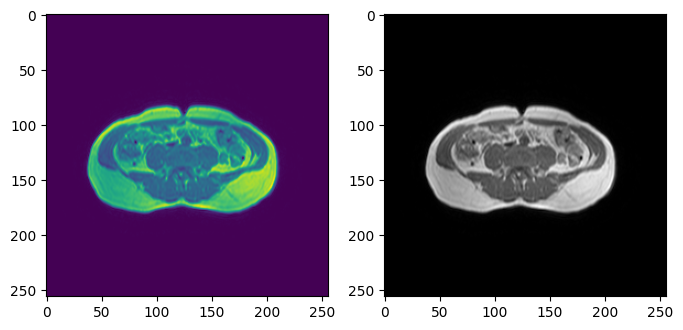

In [67]:
fig = plt.figure(figsize=(8,8))
a = fig.add_subplot(1,2,1)
imgplot = plt.imshow(ct_img)
a = fig.add_subplot(1,2,2)
imgplot = plt.imshow(ct_img, cmap = 'gray')

In [68]:
pat_path_1 = './CHAOS_Train_Sets/Train_Sets/MR/1/T1DUAL/DICOM_anon/InPhase'
dcm_ext = '.dcm'

In [69]:
#Creo un volume di un paziente

img_vol = []
for path, _, files in sorted(os.walk(pat_path_1)): 
  for filename in (sorted(files)): 
      if filename.endswith (dcm_ext):
        print (filename)
        img_dcm_std = dicom.dcmread(os.path.join(pat_path_1,filename))

        img = img_dcm_std.pixel_array
        img_vol.append (img)
    
  z_space = img_dcm_std.SpacingBetweenSlices
  x_space = img_dcm_std.PixelSpacing [0]
  y_space = img_dcm_std.PixelSpacing [1]
  vox_dim_1 = (x_space, y_space, z_space)

  img_vol_raw_1 = np.array (img_vol)
    

IMG-0004-00002.dcm
IMG-0004-00004.dcm
IMG-0004-00006.dcm
IMG-0004-00008.dcm
IMG-0004-00010.dcm
IMG-0004-00012.dcm
IMG-0004-00014.dcm
IMG-0004-00016.dcm
IMG-0004-00018.dcm
IMG-0004-00020.dcm
IMG-0004-00022.dcm
IMG-0004-00024.dcm
IMG-0004-00026.dcm
IMG-0004-00028.dcm
IMG-0004-00030.dcm
IMG-0004-00032.dcm
IMG-0004-00034.dcm
IMG-0004-00036.dcm
IMG-0004-00038.dcm
IMG-0004-00040.dcm
IMG-0004-00042.dcm
IMG-0004-00044.dcm
IMG-0004-00046.dcm
IMG-0004-00048.dcm
IMG-0004-00050.dcm
IMG-0004-00052.dcm
IMG-0004-00054.dcm
IMG-0004-00056.dcm
IMG-0004-00058.dcm
IMG-0004-00060.dcm
IMG-0004-00062.dcm
IMG-0004-00064.dcm
IMG-0004-00066.dcm
IMG-0004-00068.dcm
IMG-0004-00070.dcm


In [70]:
mid_slice_1 = int(np.round(img_vol_raw_1.shape[0]/2))

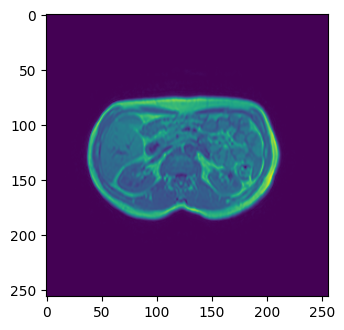

In [71]:
fig = plt.figure(figsize=(8,8))
a = fig.add_subplot(1,2,1)
imgplot = plt.imshow(img_vol_raw_1 [mid_slice_1, :, :])

In [72]:
target_resolution = [1, 1, 1]
scale_vector_1 = (vox_dim_1[0]/target_resolution[0], vox_dim_1[1]/target_resolution[1], vox_dim_1[2]/target_resolution[2])
isotr_img_1 = skimage.transform.rescale(img_vol_raw_1, scale_vector_1, order=1, preserve_range=True,  mode='constant')


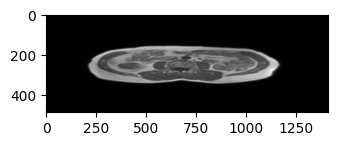

In [73]:
fig = plt.figure(figsize=(8,8))
a = fig.add_subplot(1,2,1)
imgplot = plt.imshow(isotr_img_1 [mid_slice_1, :, :], cmap = 'gray')

In [74]:
print(vox_dim_1)

('1.89453125', '1.89453125', '5.5')


Adesso dovrei caricarmi tutto il dataset e calcolarmi le dimensioni devi voxel medi e fare il resampling e reshaping (rescale e zoom) e poi normalizzare i contrasti.
Posso farlo sia tutto insieme che per T1 e T2 oppure per T1-InPhase,T1-outOfphase e T2.  


In [75]:
#################################################################
dcm_ext = '.dcm'
def laod_single_volume(folder_path):
    img_vol = []
    voxel_z = []
    voxel_x = []
    voxel_y = []
    for path, _, files in sorted(os.walk(folder_path)): 
      for filename in (sorted(files)): 
          if filename.endswith (dcm_ext):
            #print (filename)
            img_dcm_std = dicom.dcmread(os.path.join(folder_path,filename))

            img = img_dcm_std.pixel_array
            img_vol.append (img)
            
            voxel_z.append (img_dcm_std.SpacingBetweenSlices)
            voxel_x.append (img_dcm_std.PixelSpacing [0])
            voxel_y.append (img_dcm_std.PixelSpacing [1])
      
      voxel_z = np.array(voxel_z)
      voxel_x = np.array(voxel_x)
      voxel_y = np.array(voxel_y)      
      z_space = voxel_z.mean()
      x_space = voxel_x.mean()
      y_space = voxel_y.mean()
      vox_dim = (x_space, y_space, z_space)
    return (np.array(img_vol),vox_dim)

In [76]:
#######################################################################################
#Carico un array di volumi
volumes = []
vox_sizes = []
root_path="./CHAOS_Train_Sets/Train_Sets/MR/"

for subdir in os.listdir(root_path):
    vol, dim = laod_single_volume(root_path+subdir+"/T1DUAL/DICOM_anon/InPhase")
    volumes.append(vol)
    vox_sizes.append(dim)
    #vol, dim = laod_single_volume(root_path+subdir+"/T1DUAL/DICOM_anon/OutPhase")
    #volumes.append(vol)
    #vox_sizes.append(dim)
    


In [77]:
print(volumes[0].shape)

(35, 256, 256)


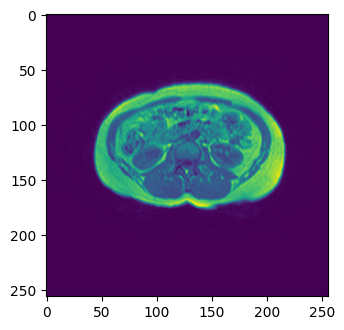

In [78]:
fig = plt.figure(figsize=(8,8))
a = fig.add_subplot(1,2,1)
imgplot = plt.imshow(volumes[0] [5, :, :])


In [79]:

###############################################################################################
#Compute mean voxel dimension
vox_sizes = np.array(vox_sizes)
target_resolution = vox_sizes.mean(axis = 0)


In [80]:
print(target_resolution)

[1.64887152 1.64887152 8.275     ]


In [81]:
#################################################################################################
#Trasformo tutti i volumi
for i in range(0,len(volumes)):
    scale_vector = (vox_sizes[i][0]/target_resolution[0],vox_sizes[i][1]/target_resolution[1],vox_sizes[i][1]/target_resolution[1])
    volumes[i] = skimage.transform.rescale(volumes[i],scale_vector, order = 3, preserve_range=True, mode='constant')
    

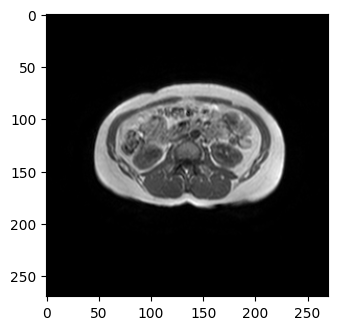

In [82]:
fig = plt.figure(figsize=(8,8))
a = fig.add_subplot(1,2,1)
imgplot = plt.imshow(volumes[0] [5, :, :], cmap = 'gray')

In [83]:
target_shape = [33, 256, 256]
#RESHAPE IMAGES
for i in range(0,len(volumes)):
    factors = (
        target_shape[0]/volumes[i].shape[0],
        target_shape[1]/volumes[i].shape[1],
        target_shape[2]/volumes[i].shape[2]
    )
    volumes[i] = zoom (volumes[i], factors, order = 3, mode = 'nearest')

In [46]:
print(volumes[2].shape)

(33, 256, 256)


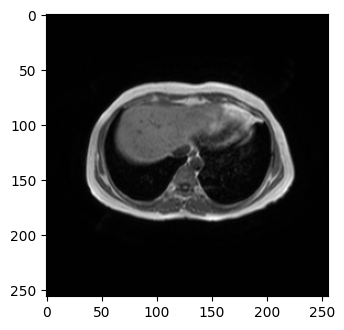

In [61]:
fig = plt.figure(figsize=(8,8))
a = fig.add_subplot(1,2,1)
imgplot = plt.imshow(volumes[0] [30, :, :], cmap = 'gray')

In [86]:
##Normalize image distribution
volumes_o = np.float32(volumes.copy())
m = np.mean(volumes_o)
s = np.std(volumes_o)
normalized_volumes = np.divide((volumes_o - m ),s)

In [89]:
np.max(volumes_o)

1.0

In [88]:
volumes_o = np.divide(volumes_o - np.min(volumes_o),np.max(volumes_o) - np.min(volumes_o))

In [94]:
#save dataset
np.save("./normalized_dataset",volumes_o)

In [95]:
normalized_volumes = np.load("./normalized_dataset.npy")

In [74]:
print(normalized_volumes.shape)

(20, 33, 256, 256)


In [75]:
#Let's do the same thing for the labels (ground truths)
#################################################################
from PIL import Image

dcm_ext = '.png'
def laod_volume_labels(folder_path):
    img_vol = []
    for path, _, files in sorted(os.walk(folder_path)): 
      for filename in (sorted(files)): 
          if filename.endswith (dcm_ext) and int(filename[-6:-5])%2 == 0:
            #print (filename)
            label_img = np.array(Image.open(os.path.join(folder_path,filename)))
            img_vol.append (label_img)
    return np.array(img_vol)

In [76]:
#######################################################################################
#Load an array of volumes of masks
vols_labels = []

root_path="./CHAOS_Train_Sets/Train_Sets/MR/"

for subdir in os.listdir(root_path):
    lab_vol = laod_volume_labels(root_path+subdir+"/T1DUAL/Ground/")
    vols_labels.append(lab_vol)
    
    #vol, dim = laod_single_volume(root_path+subdir+"/T1DUAL/DICOM_anon/InPhase")
    #volumes.append(vol)
    #vox_sizes.append(dim)
    
    #vol, dim = laod_single_volume(root_path+subdir+"/T1DUAL/DICOM_anon/OutPhase")
    #volumes.append(vol)
    #vox_sizes.append(dim)
    


In [77]:
target_shape = [33, 256, 256]

print(target_shape)

[33, 256, 256]


In [78]:
#RESHAPE MASKS
for i in range(0,len(vols_labels)):
    factors = (
        target_shape[0]/vols_labels[i].shape[0],
        target_shape[1]/vols_labels[i].shape[1],
        target_shape[2]/vols_labels[i].shape[2]
    )
    vols_labels[i] = zoom (vols_labels[i], factors, order = 0, mode = 'nearest')

In [79]:
print(vols_labels[5].shape)

(33, 256, 256)


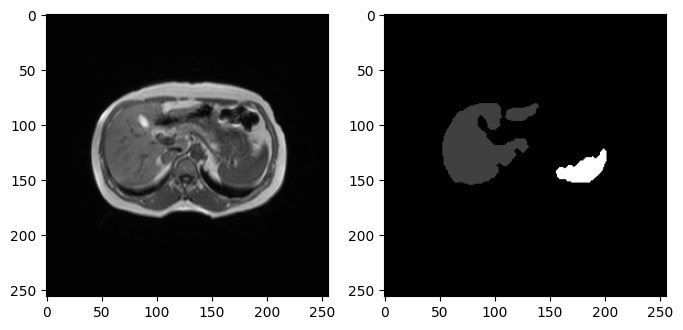

In [80]:
#Visualize mask
fig = plt.figure(figsize=(8,8))
a = fig.add_subplot(1,2,1)

imgplot = plt.imshow(volumes[0] [19, :, :], cmap = 'gray')
a = fig.add_subplot(1,2,2)
imgplot = plt.imshow(vols_labels[0] [19, :, :], cmap = 'gray')


In [81]:
vols_labels = np.array(vols_labels)
print(vols_labels.shape)

(20, 33, 256, 256)


In [82]:
#save masks
np.save("./labels",vols_labels)

########################################################################################################